# A regularized covariance discriminant analysis approach with a simple example

Assume we have two random processes $x_1$ and $x_2$. The loss function for CDA is:

$$
J_{\text{CDA}}(v) = \frac{v^T C_1 v}{v^T C_2 v}.
$$

In Martha's recent results, CDA was effective at finding variability that was much more prominent in high-res CESM than low-res (and vice versa). However, the approach left open the possibility that those modes captured a small fraction of variability in one or both models. To arrive at a CDA solution that prioritizes features that appear prominently in one of the processes (here, $x_2$), we can add an additional regularizing term, weighting the two terms by **$\alpha$** and **$\beta$**:

$$
J(v) = \alpha \frac{v^T C_1 v}{v^T C_2 v} + \beta v^T C_2^{-1} v.
$$

In the limit where **$\alpha/\beta \gg 1$**, we recover CDA, and when **$\beta/\alpha \gg 1$**, we recover the EOFs of **$x_2$**. 
For intermediate values, we obtain features that have different variances in the two systems, while also prioritizing a large variance in **$x_2$**.

There may be a closed-form solution for this new loss function, but I haven't found it. 
In the examples below, it was quick to compute the leading patterns on states 
with order hundreds of elements using a scipy optimization function.

In [47]:
# Import packages

import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
from scipy.optimize import minimize
from IPython.display import display, Math


In [117]:
# Define functions

def precompute_svd(X2):
    """Compute the SVD of X2 once to avoid redundant computations."""
    U, S, Vt = np.linalg.svd(X2, full_matrices=False)
    return U, S, Vt

def J(v, X1, X2_svd, alpha=1.0, beta=1.0):
    """Compute the regularized cost function with Mahalanobis term, using precomputed SVD."""
    U, S, Vt = X2_svd
    C1_v = (X1.T @ v).T @ (X1.T @ v)  # Quadratic form for C1
    C2_v = (X2.T @ v).T @ (X2.T @ v)  # Quadratic form for C2
    
    # Compute Mahalanobis term using precomputed SVD
    C2_inv_v = U @ np.diag(1 / (S + 1e-6)) @ U.T @ v  # Regularized inverse via SVD
    mahalanobis_term = v.T @ C2_inv_v
    
    return alpha * (C1_v / C2_v) + beta * mahalanobis_term

def grad_J(v, X1, X2_svd, alpha=1.0, beta=1.0):
    """Compute the gradient of the regularized cost function."""
    U, S, Vt = X2_svd
    C1_v = X1 @ (X1.T @ v)  # Gradient term from C1
    C2_v = X2 @ (X2.T @ v)  # Gradient term from C2
    vC2v = v.T @ C2_v  # Scalar value for denominator
    
    term1 = 2 * alpha * C1_v / vC2v  # First term gradient
    term2 = 2 * alpha * ((v.T @ C1_v) / vC2v**2) * C2_v  # Second term gradient
    
    # Compute Mahalanobis gradient term using precomputed SVD
    C2_inv_v = U @ np.diag(1 / (S + 1e-6)) @ U.T @ v
    mahalanobis_grad = 2 * beta * C2_inv_v  # Gradient of Mahalanobis term
    
    return term1 - term2 + mahalanobis_grad

def optimize_J(X1, X2, alpha=1.0, beta=1.0):
    """Optimize the cost function using BFGS, with precomputed SVD of X2."""
    n = X1.shape[0]  # Number of spatial locations
    v0 = np.random.randn(n)
    v0 /= np.linalg.norm(v0)  # Normalize initial v
    
    X2_svd = precompute_svd(X2)  # Precompute SVD of X2
    
    def obj_func(v):
        return J(v, X1, X2_svd, alpha, beta)
    
    def grad_func_wrapped(v):
        return grad_J(v, X1, X2_svd, alpha, beta)
    
    result = minimize(obj_func, v0, jac=grad_func_wrapped, method='BFGS')
    v_opt = result.x / np.linalg.norm(result.x)  # Re-project onto the unit sphere
    
    return v_opt

def variance_explained(v, X):
    """Compute the variance explained by v in X."""
    C_v = (X.T @ v).T @ (X.T @ v)  # Quadratic form for variance
    return C_v / np.sum(X * X) # the denominator is total variance


For the example below, I'm generating "broadband" and "large-scale" processes by smoothing white noise with different length Gaussian filters. These are meant to represent output from high- and low-res CESM output, respectively.

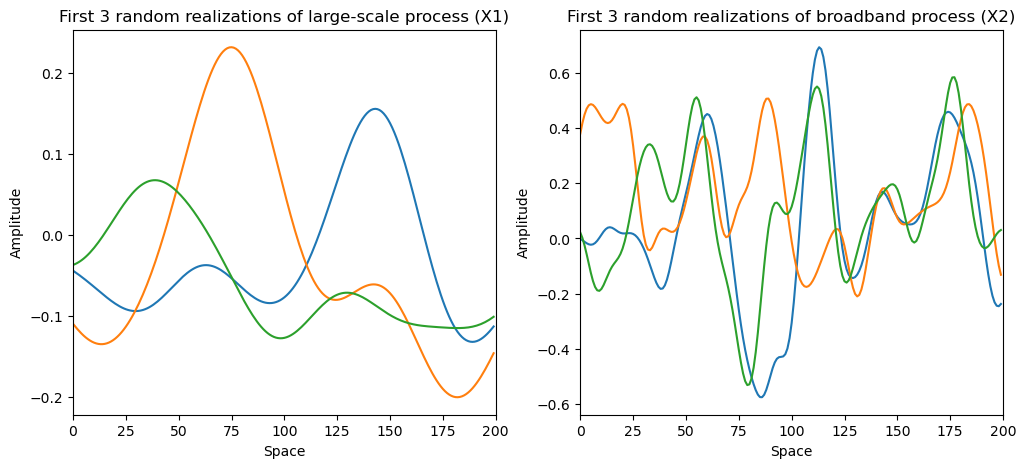

In [108]:
# Define some dimensions

# Size of state
Nx = 200
# Number of ensemble members
Ne = 1000

# Spatial smoothing length scale
ss1 = Nx/10
ss2 = Nx/40.

# Generate two data matrices
Xu1 = rvec(Nx,Ne,ss1)
X1 = (Xu1-np.mean(Xu1,1,keepdims=True))
Xu2 = rvec(Nx,Ne,ss2)
X2 = (Xu2-np.mean(Xu2,1,keepdims=True))

# Plot realizations
f, (a0, a1) = plt.subplots(1, 2, figsize=(12,5))

a0.plot(X1[:,:3])
a0.set_title('First 3 random realizations of large-scale process (X1)')
a0.set_ylabel('Amplitude')
a0.set_xlabel('Space')
a0.set_xlim([0,Nx])

a1.plot(X2[:,:3])
a1.set_title('First 3 random realizations of broadband process (X2)')
a1.set_ylabel('Amplitude')
a1.set_xlabel('Space')
a1.set_xlim([0,Nx])

plt.show();

Next, I perform the optimization for cases of $\alpha$ and $\beta$ corresponding to CDA and EOF calculations, as well as a regularized CDA where $\alpha=\beta=1$. In practice it may be worth experimenting with different intermediate values of $\alpha$ and $\beta$ depending on desired features. In this example, we see that the CDA solution has a lot of high-wavenumber variability, qualitatively similar to what Martha found for CDA on CESM. This is in contrast to the leading EOF of the large-scale system, which is much smoother. The regularized CDA case lies in between -- maybe a bit less smooth, but much more similar to the EOF than CDA solution.

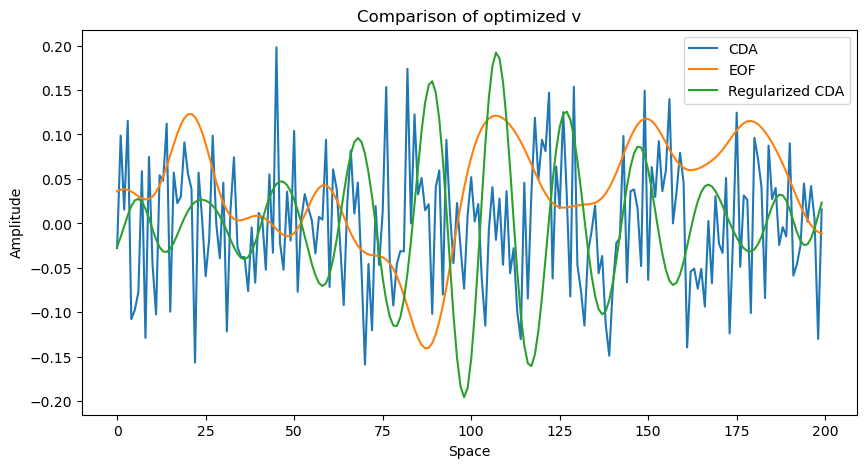

In [113]:
# Optimize for choices of alpha and beta
v_opt_reg = optimize_J(X1, X2, alpha=1.0, beta=1.0)
v_opt_CDA = optimize_J(X1, X2, alpha=1.0, beta=0.0)
v_opt_EOF = optimize_J(X1, X2, alpha=0.0, beta=1.0)

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(v_opt_CDA, label='CDA')
plt.plot(v_opt_EOF, label='EOF')
plt.plot(v_opt_reg, label='Regularized CDA')
plt.xlabel("Space")
plt.ylabel("Amplitude")
plt.legend()
plt.title(f"Comparison of optimized v")
plt.show()

Next we quantify the fraction of total variance explained by the three vectors in the two systems. As expected, CDA finds a vector that explains a much higher amount of variance in $x_2$ than in $x_1$, though the actual amount of variance in both systems is quite small. At the other extreme, the leading EOF explains substantial and relatively similar fraction of variance in both systems. Regularized CDA is a compromise, finding a pattern that explains a significant amount of variance in $x_2$ and a much lower relative amount (10x less) in $x_1$.

In [118]:

# Compute variance explained and discriminant ratio for each method
var_explained_reg_X1 = variance_explained(v_opt, X1)
var_explained_reg_X2 = variance_explained(v_opt, X2)
discriminant_ratio_reg = var_explained_reg_X1 / var_explained_reg_X2

var_explained_CDA_X1 = variance_explained(v_opt_CDA, X1)
var_explained_CDA_X2 = variance_explained(v_opt_CDA, X2)
discriminant_ratio_CDA = var_explained_CDA_X1 / var_explained_CDA_X2

var_explained_EOF_X1 = variance_explained(v_opt_EOF, X1)
var_explained_EOF_X2 = variance_explained(v_opt_EOF, X2)
discriminant_ratio_EOF = var_explained_EOF_X1 / var_explained_EOF_X2

# Generate LaTeX table
latex_table = rf"""
\begin{{array}}{{|c|c|c|c|}}
\hline
\textbf{{Method}} & \textbf{{Var. Fraction (X1)}} & \textbf{{Var. Fraction (X2)}} & \textbf{{Discriminant Ratio (X1/X2)}}\\
\hline
\text{{CDA}} & {var_explained_CDA_X1:.4f} & {var_explained_CDA_X2:.4f} & {discriminant_ratio_CDA:.4f}\\
\text{{EOF}} & {var_explained_EOF_X1:.4f} & {var_explained_EOF_X2:.4f} & {discriminant_ratio_EOF:.4f}\\
\text{{Regularized CDA}} & {var_explained_reg_X1:.4f} & {var_explained_reg_X2:.4f} & {discriminant_ratio_reg:.4f}\\
\hline
\end{{array}}
"""

# Display the LaTeX table
display(Math(latex_table))


<IPython.core.display.Math object>